In [1]:
# Fill in your name using the format below and student ID number
your_name = "Teixeira Militao, Daniel"
student_id = "1486314"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
tensorflow_version = tf.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Daniel, Looks good. You may continue :)


In [7]:
# Move all imports here
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, PowerTransformer

import matplotlib.patheffects as PathEffects

import cv2
import gzip
import os
import pickle

# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [8]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = 'C:\\Users\\danie\\TUe\\WebInfo\\assignments\\assignment-3-D-Militao\\'

In [9]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [10]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [11]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [12]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [13]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

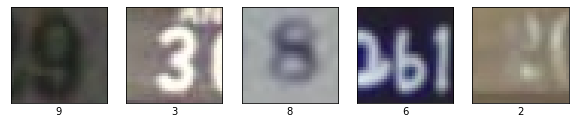

In [14]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            im = np.squeeze(X[n])
            axes[n].imshow(im, cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [15]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

# New version from canvas
def load_model_from_file(base_dir, name, extension='.h5'):
  """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
  function following the Keras API. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  try:
    # if a json description is available, load config and then weights
    if os.path.isfile(os.path.join(base_dir, name+'.json')):
      json_file = open(os.path.join(base_dir, name+'.json'), 'r')
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json)
      model.load_weights(os.path.join(base_dir, name+extension))
    # else just load the entire model from hdf5 file
    else:
      model = load_model(os.path.join(base_dir, name+extension))
  except OSError:
    shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
    return False
  return model

# New version from canvas
def save_model_to_file(model, base_dir, name, extension='.h5'):
  """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  path = os.path.join(base_dir, name+extension)
  model.save(path)
  size = os.path.getsize(path)
  # If model > 100MB, store the weights and architecture only.
  if size > 100*1024*1024:
    print("Model larger than 100MB, storing weights only.")
    model.save_weights(path)
    model_json = model.to_json()
    with open(os.path.join(base_dir, name+".json"), "w") as json_file:
        json_file.write(model_json)


# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

In [16]:
# Set seed
tf.random.set_seed(1)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_113 (Dense)            (None, 256)               786688    
_________________________________________________________________
dense_114 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_115 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_116 (Dense)            (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.422874  0.263975  0.

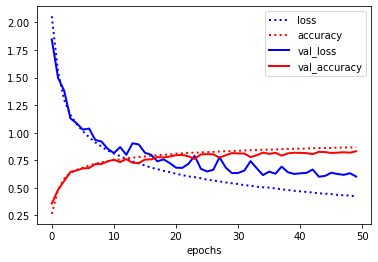

In [39]:
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
                train=False, epochs=50, batch_size=32)

answer_q_1_1 = """
I started with 3 layers with few nodes and increased the model's complexity until it wasn't underfitting.
Then, I used GridSearchCV with different optimizers to tune the hyperparameters.
Some optimizers needed a more complex model.
With enough tuning their performance was comparable.
I chose SGD because it converges the fastest.
I used batch size 32 because higher sizes decreased performance.
The current model is overfitting on purpose to give room for improvement in the next questions.
"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

In [ ]:
# I run grid search only on the train dataset
# It means I use less data but I don't want the validation data to influence
# def build_model_1_1_grid_search(learning_rate=0.01):
#     model = models.Sequential()
#     model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
#     model.add(layers.Dense(256, activation='relu'))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))
#     model.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model
#
# kerasClf = KerasClassifier(build_model_1_1_grid_search)
# parameter_grid = {'epochs': [10,30,50],  
#                   'batch_size': [32,64],
#                   'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1], 
#                   'verbose' : [0]}
#
# grid = GridSearchCV(kerasClf, param_grid=param_grid, scoring='accuracy', cv=3, return_train_score=True)
# y_grid = (np.argmax(preprocessed_split[2], axis=1)+1)%10
# grid.fit(preprocessed_split[0], y_grid)

In [ ]:
# Test batch_size
# The larger the batch_size the faster it trained but we start seeing worse and more irregular results each epoch
# Highly debated topic, but we can say large batchsize cause over-fitting and it converges to a sharp minima: https://arxiv.org/abs/1609.04836
# run_evaluation("model_1_1_32", build_model_1_1, evaluation_split, base_dir, 
#                train=False, epochs=20, batch_size=32)
# run_evaluation("model_1_1_64", build_model_1_1, evaluation_split, base_dir, 
#                train=False, epochs=20, batch_size=64)
# run_evaluation("model_1_1_128", build_model_1_1, evaluation_split, base_dir, 
#                train=False, epochs=20, batch_size=128)
# run_evaluation("model_1_1_256", build_model_1_1, evaluation_split, base_dir, 
#                train=False, epochs=20, batch_size=256)
# run_evaluation("model_1_1_512", build_model_1_1, evaluation_split, base_dir, 
#                train=False, epochs=20, batch_size=512)

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [40]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

# Store as float32
X_train_grayscale = rgb2gray(X_train).astype(np.float32)
X_val_grayscale = rgb2gray(X_val).astype(np.float32)
X_test_grayscale = rgb2gray(X_test).astype(np.float32)
preprocessed_split = X_train_grayscale, X_val_grayscale, y_train, y_val

Loading model from file
Success!
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_117 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_118 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_119 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_120 (Dense)            (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.419650  0.219926  0.

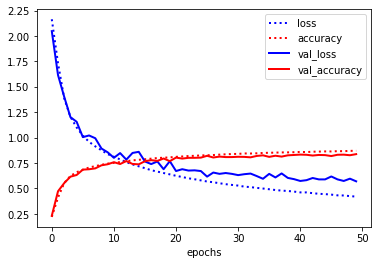

In [41]:
# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=32)

answer_q_1_2 = """
The data was grayscaled and stored as float32.
We now have a kernal of size 32x32x1 and the values are between 0 and 1.
Float32 allows us to store twice the content in memory at the cost of negligible loss of precision.
We get lower losses and higher accuracies sooner and before the model starts to overfit.
Grayscaling our data is beneficial because the color in this case is irrelevant.
Since memory is often the bottleneck float32 is a good trade-off and it didn't seem to affect performance.
"""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_42 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_174 (Dense)            (None, 256)               262400    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_175 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_39 (Dropout)

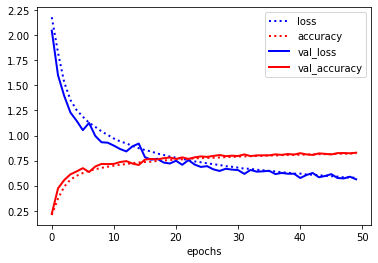

In [44]:
def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=32)
answer_q_1_3 = """
L1 regularization negatively affected the model unless the alpha was low and at that point there was barely any noticible change.
L2 regularization did improve the model over the original.
I tried combining L1 and L2 but once again the L1 alpha had to be so low that the result was the same as using just L2.
Dropout at 1st didn't look promising, but if decreased enough it provided the best results.
I tried integrating BatchNormalization but it made the learning quite erratic.
"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_27 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)  

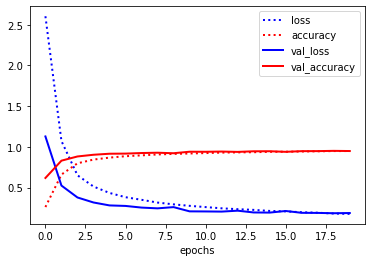

In [45]:
def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=20, batch_size=64)

answer_q_2_1 = """
I increased the model's complexity until I was unable to decrease the validation losses further without overfitting.
This way I achieved a max accuracy of around 92%.
I then further increased it's complexity, causing overfitting so I added regularization to deal with it.
The best architecture is a VGG like model similar to the one used in the lab.
I noticed the loss decreased too quickly so I decreased the learning rate slightly.
I added dropout because it's an effective regularization method.
Gradually increased it to force the layers deep in the model to regularize more than layers closer to the input.
Great results.
Still takes a long time to train so I added batch normalization to make it easier to learn and generalize.
Stopped at epoch 20 to prevent the model from overfitting.
"""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_170 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_171 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_142 (Conv2D) 

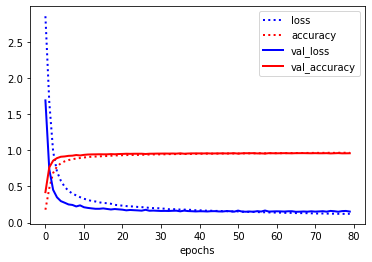

In [51]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
augmented_split = preprocessed_split

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1)

it_train = train_datagen.flow(augmented_split[0], augmented_split[2], batch_size=64)

steps = int(augmented_split[0].shape[0] / 64)

run_evaluation("model_2_2", build_model_2_1, (it_train, augmented_split[1], augmented_split[3]), base_dir, 
               train=False, generator=True, epochs=80, batch_size=None, steps_per_epoch=steps)

answer_q_2_2 = """
Our image size is so small we lose too much info if we apply too much data augmentation.
Combining every technique that didn't decrease performance was best.
Shifting too much meant the model predicted the digits next to the centered one.
Flips make it harder to discern between certain numbers.
The performance didn't change much since we cannot alter images too much, i.e., little variation is generated.
We can train for longer without overfitting and our model is moresurerut its predictions.
"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [22]:
model_2_2 = load_model_from_file(base_dir, "model_2_2")
model_2_2.evaluate(X_test_grayscale, y_test)
y_pred = model_2_2.predict(X_test_grayscale)

19858/19858 [==============================] - 8s 422us/sample - loss: 0.1572 - accuracy: 0.9616


In [52]:
test_accuracy_3_1 = 0.9616

def plot_confusion_matrix():
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(cm)
    fig.colorbar(im)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    labels = np.array(list(range(1,11)))%10
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    for i in range(100):
        txt = ax.text(int(i/10), i%10, cm[i%10,int(i/10)], ha="center", va="center", color="black")
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
    fig.suptitle('Confusion matrix', fontsize=16)
    plt.show();

def plot_misclassifications():
    label = 1
    misclassified_samples = np.nonzero((np.logical_and(
        np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1),
        (np.argmax(y_test, axis=1)+1)%10 == (label))))[0]
    print(misclassified_samples.size)
    images = np.random.choice(misclassified_samples, 10)
    fig, ax = plt.subplots(2, len(images), figsize=(20, 5))
    for nr, i in enumerate(images):
        ax[0][nr].imshow(X_test[i], cmap='gray')
        im = np.squeeze(X_test_grayscale[i])
        ax[1][nr].imshow(im, cmap='gray')
        ax[1][nr].set_xlabel("Sample: %d,\n Predicted: %d,\nActual: %d" % (i, (np.argmax(y_pred[i])+1)%10, (np.argmax(y_test[i])+1)%10))
        ax[0][nr].set_xticks(()), ax[0][nr].set_yticks(())
        ax[1][nr].set_xticks(()), ax[1][nr].set_yticks(())
    fig.suptitle('Misclassifications of class %d' % (label), fontsize=16)
    plt.show();

# As said in the forum the answer can have up to 800 characters
answer_q_3_1 = """
In the convolution matrix we can see the numbers with similar shapes are more often confused, e.g., 6-5, 1-7 which makes sense.
Interesting to note that an actual 6 often is predicted as 5 but an actual 5 is not often predicted as 6, it's often predicted as 3.
Label 3 was the label most incorrectly predicted while actual label 1 has the most incorrect prediction althought there are a lot more 1 samples.

When plotting misclassifications, I chose to focus on misclassification of class 1.
I realized that the actual digit wasn't always the one centered (2780) and there were quite a few mislabled samples (16392).
Furthermore, most other misclassifications were due to the image being too blurry (720) or there not being enough contrast between the digit and the background.
"""
print("Answer is {} characters long".format(len(answer_q_3_1)))

Answer is 779 characters long


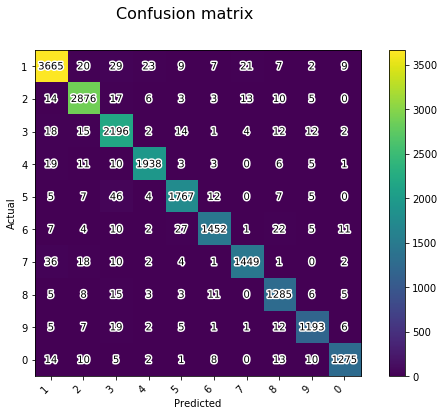

In [137]:
plot_confusion_matrix()

127


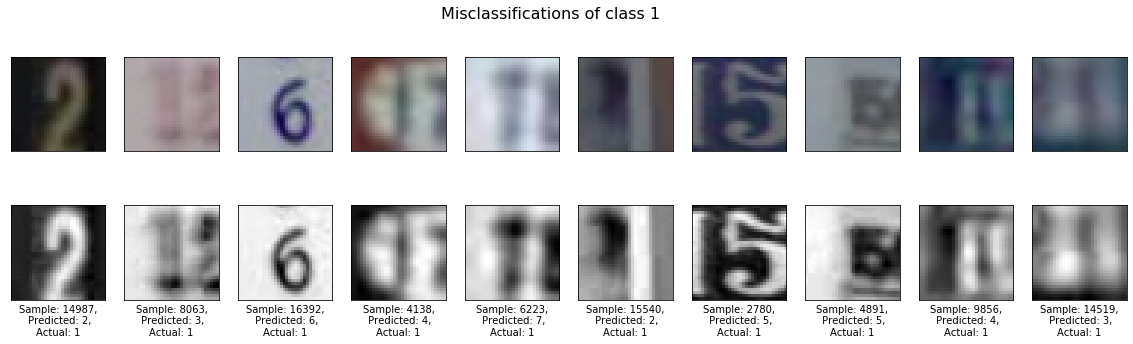

In [138]:
plot_misclassifications()

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [53]:
def plot_activation(layer_index, layer_name, layer_activation):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    images_per_row = 20
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                            row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
    plt.grid(False)
    im = plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.colorbar(im)
    plt.show()

def plot_activations():
    # load model
    model_2_2 = load_model_from_file(base_dir, "model_2_2")

    # get 1st sample
    img_tensor = X_test_grayscale[0]
    img_tensor = np.expand_dims(img_tensor, axis=0) 

    # Double check if our model actually managed to predict it correctly
    # Depending on whether or not it did, it changes how we interpret the activations
    pred = model_2_2.predict(img_tensor)
    pred_label = (np.argmax(pred)+1)%10
    actual_label = (np.argmax(y_test[0])+1)%10
    print("Predicted: %d\nActual: %d" % (pred_label, actual_label))

    # get activations
    layer_outputs = [layer.output for layer in model_2_2.layers]
    activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)

    layer_names = []
    for layer in model_2_2.layers:
        layer_names.append(layer.name)

    for nr, layer_name in enumerate(layer_names):
        if layer_name.startswith('conv2d'):
            plot_activation(nr, layer_name, activations[nr])

answer_q_3_2 = """
The first layer retain almost all of the information present in the initial picture.
Some filters are not activated, they might activate for a different number, for example.
As we go deeper in the layers, the activations become increasingly abstract and less visually interpretable.
They begin to encode higher-level concepts such as single borders, corners and angles.
We get less information about the visual contents of the image, and more information related to the class of the image.
"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

Answer is 491 characters long


Predicted: 8
Actual: 8


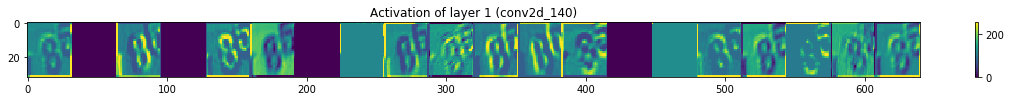

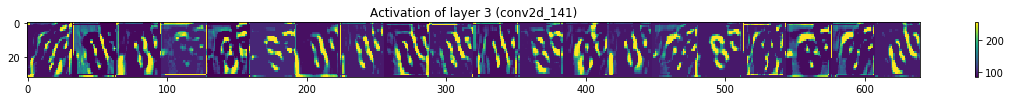

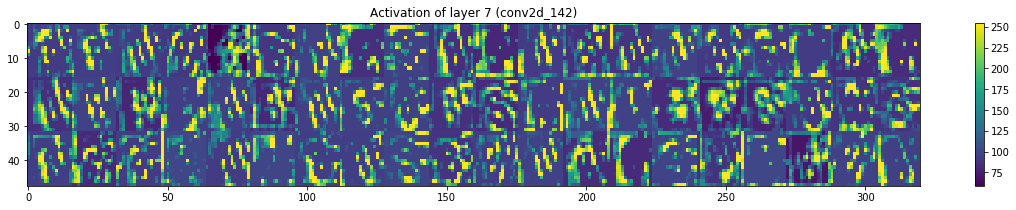

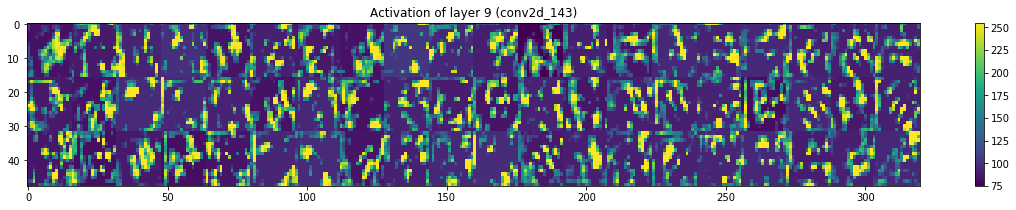

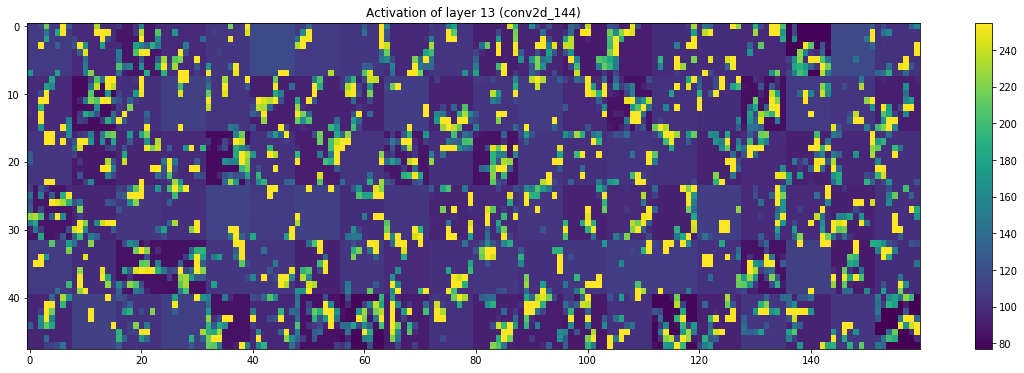

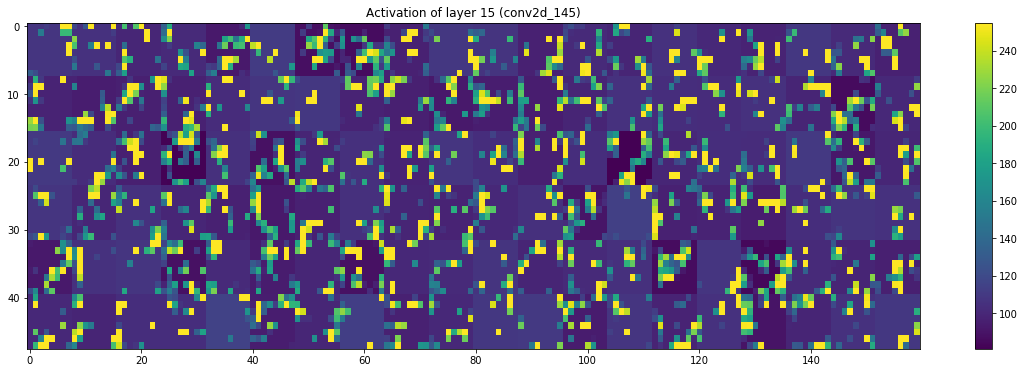

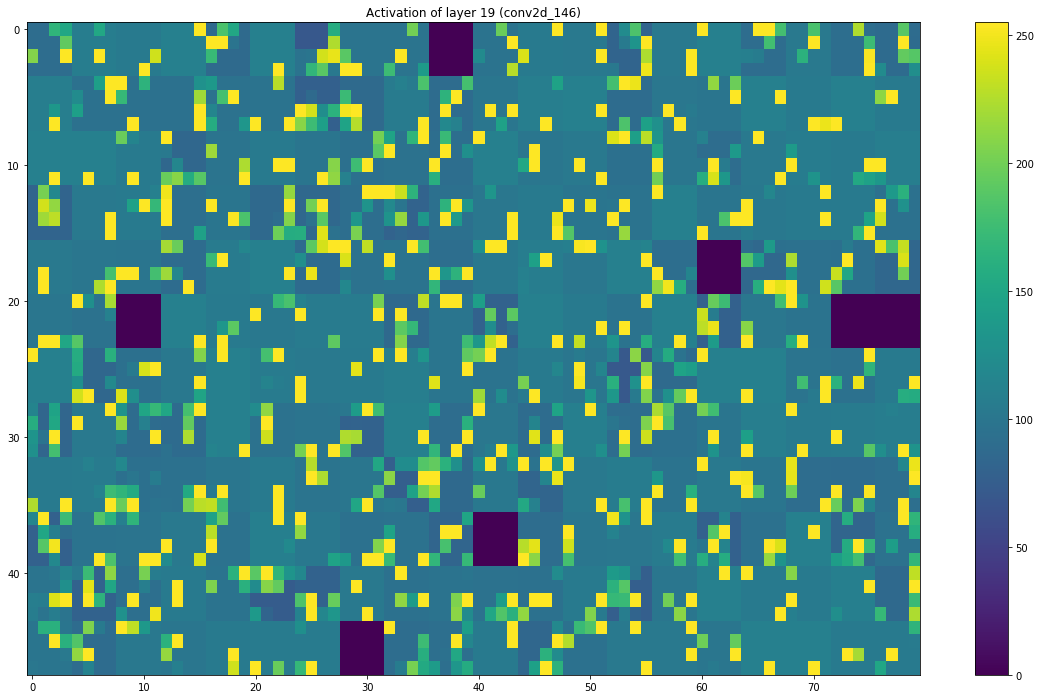

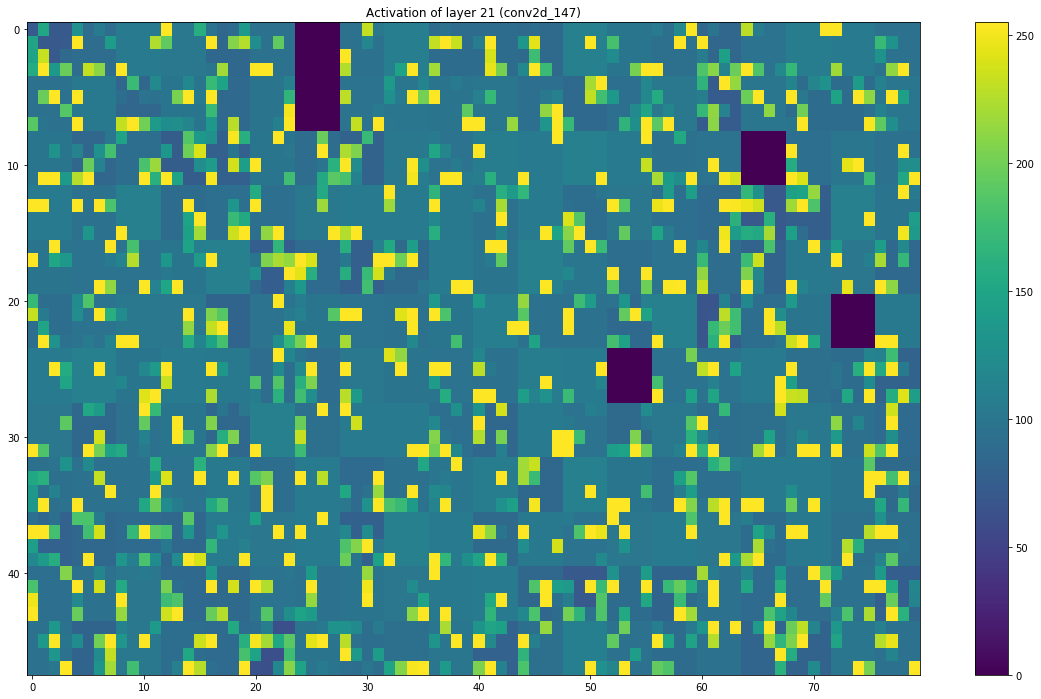

In [27]:
plot_activations()

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Predicted: 8
Actual: 8


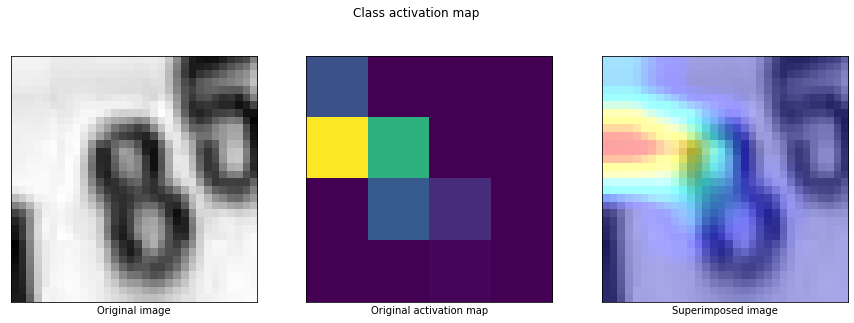

In [84]:
def plot_3_3():
    # load model
    model_2_2 = load_model_from_file(base_dir, "model_2_2")

    # get sample
    index = 0
    img = X_test_grayscale[index]
    img_tensor = np.expand_dims(img, axis=0)

    # Double check if our model actually managed to predict it correctly
    # Depending on whether or not it did, it changes how we interpret the activations
    pred = model_2_2.predict(img_tensor)
    pred_label = (np.argmax(pred)+1)%10
    actual_label = (np.argmax(y_test[index])+1)%10
    print("Predicted: %d\nActual: %d" % (pred_label, actual_label))

    with tf.GradientTape() as tape:
        last_conv_layer = model_2_2.get_layer('conv2d_147')
        iterate = tf.keras.models.Model([model_2_2.inputs], [model_2_2.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(img_tensor)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((4, 4))
    
    INTENSITY = 0.002
    # We resize the heatmap to have the same size as the original image
    heatmap_cv2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # We convert the heatmap to RGB
    heatmap_cv2 = np.uint8(255 * heatmap_cv2)
    # We apply the heatmap to the original image
    heatmap_cv2 = cv2.applyColorMap(heatmap_cv2, cv2.COLORMAP_JET)
    # We make sure it's RGB because for some GOD DAMN REASON CV2 IS BRG AND IT TOOK TOO LONG TO FIGURE THAT OUT
    heatmap_cv2 = cv2.cvtColor(heatmap_cv2, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap_cv2 * INTENSITY + img

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    im = np.squeeze(img)
    ax[0].imshow(im, cmap='gray')
    ax[0].set_xlabel("Original image")
    ax[0].set_xticks(()), ax[0].set_yticks(())

    ax[1].matshow(heatmap)
    ax[1].set_xlabel("Original activation map")
    ax[1].set_xticks(()), ax[1].set_yticks(())
    
    ax[2].imshow(superimposed_img)
    ax[2].set_xlabel("Superimposed image")
    ax[2].set_xticks(()), ax[2].set_yticks(())

    fig.suptitle('Class activation map')
    plt.show();

plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/11
63544/63544 [==============================] - 143s 2ms/sample - loss: 1.7206 - accuracy: 0.4109 - val_loss: 1.1753 - val_accuracy: 0.6014
Epoch 2/11
63544/63544 [==============================] - 134s 2ms/sample - loss: 0.9446 - accuracy: 0.6906 - val_loss: 0.8032 - val_accuracy: 0.7363
Epoch 3/11
63544/63544 [==============================] - 134s 2ms/sample - loss: 0.7157 - accuracy: 0.7703 - val_loss: 0.6546 - val_accuracy: 0.7894
Epoch 4/11
63544/63544 [==============================] - 135s 2ms/sample - loss: 0.6105 - accuracy: 0.8065 - val_loss: 0.5780 - val_accuracy: 0.8163
Epoch 5/11
63544/63544 [==============================] - 136s 2ms/sample - loss: 0.5461 - accuracy: 0.8292 - val_loss: 0.5413 - val_accuracy: 0.8277
Epoch 6/11
63544/63544 [==============================] - 136s 2ms/sample - loss: 0.5031 - accuracy: 0.8415 - val_loss: 0.5088 - val_accuracy: 0.8398
Epoch 7/11
63544/63544 [=======

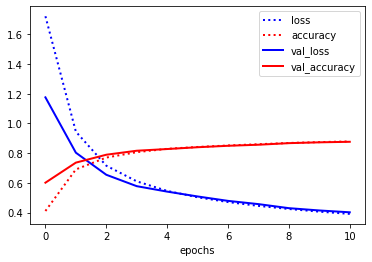

In [55]:
def build_model_4_1():
    vgg16_conv_base = VGG16(weights='imagenet', 
                            include_top=False, 
                            input_shape=(32, 32, 3))
    model = models.Sequential()
    model.add(vgg16_conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    vgg16_conv_base.trainable = True
    set_trainable = False
    for layer in vgg16_conv_base.layers:
        if layer.name.startswith('block3'):
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=False, epochs=11, batch_size=64)

answer_q_4_1 = """
Having the whole model frozen gives really bad overfitted model because our data is different the imagenet data.
There is improvement in performance as I unfroze layers up to and including block 3.
After that our model started to overfit and even starts to perform worse.
Used very low learning rate to ensure the model wouldn't completely "unlearn" what vgg16 had learned.
Performance is lower than Q2 models because no regularization is used but that doesn't benefit the embedding.
"""
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [56]:
def store_embedding(X, name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model_4_1 = load_model_from_file(base_dir, "model_4_1")
    vgg16_conv_base = model_4_1.get_layer('vgg16')
    print("Predicting...")
    X_train_emb = vgg16_conv_base.predict(X_train)
    X_val_emb = vgg16_conv_base.predict(X_val)
    X_test_emb = vgg16_conv_base.predict(X_test)
    print("Storing...")
    store_embedding(X_train_emb, "X_train")
    store_embedding(X_val_emb, "X_val")
    store_embedding(X_test_emb, "X_test")
    print("Done!")

def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    clf = SVC()
    pipeline = Pipeline(steps=[
        ('pca', PCA(n_components=0.99, svd_solver='full')),
        ('classifier', clf)
    ])
    return pipeline

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
        evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    pipeline.fit(X_train, y_train)
    accuracy = pipeline.score(X_test, y_test)
    return accuracy

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    if not os.path.isfile(os.path.join(base_dir, 'X_train_embedding'+'.p')):
        store_embeddings()

    print("Loading embeddings...")
    X_train_emb = load_embedding("X_train")
    X_test_emb = load_embedding("X_test")

    X_train_emb_reshape = X_train_emb.reshape(np.shape(X_train_emb)[0], 512)
    y_train_reshape = (np.argmax(y_train, axis=1)+1)%10

    X_test_emb_reshape = X_test_emb.reshape(np.shape(X_test_emb)[0], 512)
    y_test_reshape = (np.argmax(y_test, axis=1)+1)%10

    print("Pipeline generated...")
    pipeline = generate_pipeline()

    print("Evaluating pipeline...")
    accuracy = evaluate_pipeline(pipeline, X_train_emb_reshape, y_train_reshape, X_test_emb_reshape, y_test_reshape)

    print("Accuracy = %f" % (accuracy))

answer_q_4_2 = """
I tried using automl but ran into many issues, unfortunately.
I experimented with BernouilliNB, RandomForests and SVC and I achieved 77%, 60% and 88% accuracy, respectively.
I achieved these results while using PCA.
None of the models beat any model developed thus far.
Which I somewhat expected because CNNs are best at image classification.
However, the embeddings should allow for non-deep learning techniques to learn efficiently.
"""
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Pipeline: Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.99,
                     random_state=None, svd_solver='full', tol=0.0,
                     whiten=False)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Answer is 436 characters long


In [18]:
evaluation_4_2(X_train, y_train, X_test, y_test)

Loading embeddings...
Pipeline generated...
Evaluating pipeline...
Accuracy = 0.877631
